In [ ]:
import numpy as np
from collections import defaultdict

M_list = [10, 30, 50, 100, 300, 500, 1000, 3000, 5000]
N_list = [17, 33, 65]#, 129]
h_list = [0.25, 0.125, 0.0625]#, 0.03125]
modelseed_list = [402025, 102025, 202025, 302025, 3070, 4080, 5090, 20250101]

In [3]:
def find_args(data, model, property, seed, M, N=17, L=-2, R=2, lambda1=1, lambda2=0):
    h = 4/(N-1)
    if model=='RFLAF':
        actfunc = 'LAF'
        moreargs=f'h={h}_N={N}_L={L}_R={R}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFLAFBS':
        actfunc = 'BS'
        moreargs=f'N={N}_L={L}_R={R}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFMLP':
        actfunc = 'relu'
        moreargs=f'M={M}'
    
    if data in ['ct', 'protein', 'workloads']:
        epochs = 20
    elif data in ['adult', 'cifar10']:
        epochs = 10
    
    foldername={
        'test_loss': 'losses',
        'train_loss': 'losses',
        'test_acc': 'accuracies',
        'train_acc': 'accuracies',
        'test_time': 'times',
        'train_time': 'times',
        'coef': 'coef',
        'features': 'features',
    }
    if property=='coef':
        return f"./{foldername[property]}/{data}_{actfunc}_{property}_seed={seed}_epoch={epochs}_{moreargs}_{epochs}.txt"
    else:
        return f"./{foldername[property]}/{data}_{actfunc}_{property}_seed={seed}_epoch={epochs}_{moreargs}.txt"

In [ ]:
datadict=dict()
data_list = ['adult', 'cifar10', 'ct', 'workloads']
model_list = ['RFLAF', 'RFMLP', 'RFLAFBS']
property_list = ['test_loss', 'train_loss', 'test_acc', 'train_acc']
for data in data_list:
    for model in model_list:
        for h, N in zip(h_list, N_list):
            taskname = data+model+f'{N}'
            datadict[taskname] = defaultdict(list)
            for M in M_list:
                for property in property_list:
                    if data in ['ct', 'workloads'] and property[-3:]=='acc':
                        continue
                    tmparr = []
                    for seed in modelseed_list:
                        tmparr.append(np.loadtxt(find_args(data, model, property, seed, M, N)))
                    tmparr = np.array(tmparr).mean(axis=0)
                    if property[-4:]=='loss':
                        tmp = float(tmparr.min())
                    elif property[-3:]=='acc':
                        tmp = float(tmparr.max())
                    datadict[taskname][property].append(tmp)

In [ ]:
rbf
N=17
ct: M=5000
workloads: M=3000,5000

N=33
workloads: M=3000,5000

BS
N=33
ct, workloads: 3000,5000
N=65
ct, workloads除了10都不行

NameError: name 'rbf' is not defined

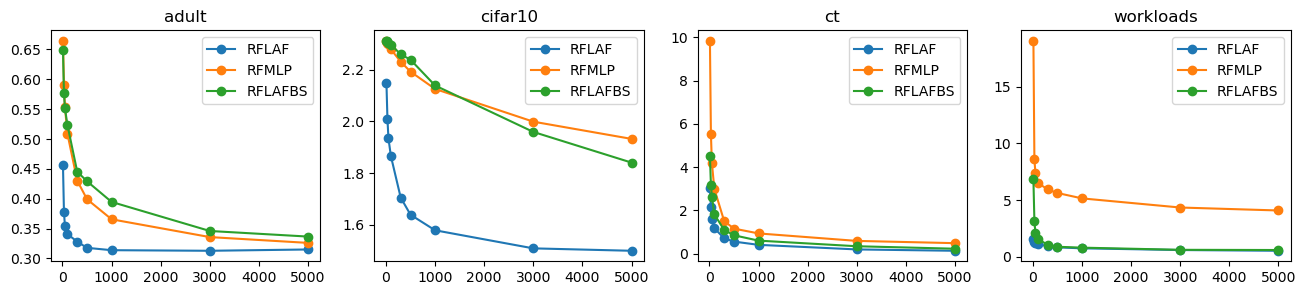

In [42]:
N=17

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for i, data in enumerate(data_list):
    for model in model_list:
        taskname = data+model+f'{N}'
        ax[i].plot(M_list, datadict[taskname]['test_loss'], marker='o')
        ax[i].legend(model_list)
        ax[i].set_title(data)

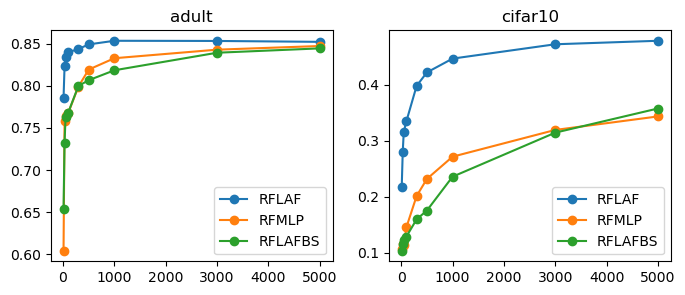

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, data in enumerate(data_list[:2]):
    for model in model_list:
        taskname = data+model+f'{N}'
        ax[i].plot(M_list, datadict[taskname]['test_acc'], marker='o')
        ax[i].legend(model_list)
        ax[i].set_title(data)

In [ ]:
M_list = [10, 30, 50, 100, 300, 500, 1000, 3000, 5000]
N_list = [17, 33, 65]
h_list = [0.25, 0.125, 0.0625]
modelseed_list = [402025, 102025, 202025, 302025, 3070, 4080, 5090, 20250101]

In [40]:
import numpy as np
data = 'cifar10'
model = 'RFLAF'
property = 'features'
seed = modelseed_list[0]
M = M_list[8]
h, N = h_list[0], N_list[0]

L, R = -2, 2
lambda1, lambda2 = 1, 0

print(f"{N=} {seed=} {M=}")
rfmatrix = np.loadtxt(find_args(data, model, property, seed, M, N))

N=17 seed=402025 M=5000


In [100]:
100, 3072, 384, 6

(100, 3072, 384, 6)

In [36]:
# d x M
rfmatrix.shape

(3072, 5000)

In [37]:
import torch
import torch.nn as nn
import numpy as np

class RBFLayer(nn.Module):
    def __init__(self, center, gamma):
        super(RBFLayer, self).__init__()
        self.c = center
        self.h = gamma

    def forward(self, input):
        result = -(input-self.c)**2/(2*self.h**2)
        return torch.exp(result)

class LeverageScore(nn.Module):
    def __init__(self, coef, features, h=0.02, N=401, seed=0, L=-2, R=2):
        super(LeverageScore, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        hlist=h * np.ones(N)
        clist=np.linspace(L, R, N)
        paralist = list(zip(clist, hlist))
        
        self.W = nn.Parameter(torch.tensor(features), requires_grad=False)
        print('weight matrix size [d, M]:', tuple(self.W.shape))
        self.a = nn.Parameter(torch.tensor(coef))
        print('coef size: [N]', tuple(self.a.shape)[0])
        self.rbfs = nn.ModuleList([RBFLayer(torch.tensor(center), torch.tensor(gamma)) for center, gamma in paralist])

    def forward(self, x, lambda0):
        # Input x: [n, input_dim]
        x = x.view(x.size(0), -1)  # Flatten input
        xW = torch.matmul(x, self.W)  # [n, M]
        A = torch.stack([rbf(xW) for rbf in self.rbfs], dim=2) # [n, M, N]
        Aa = torch.matmul(A, self.a) # [n, M]
        self.Sigma = torch.matmul(Aa.T, Aa) / x.size(0) # [M, M]
        
        self.M = self.Sigma.size(0)
        self.lambda0 = lambda0
        
        self.inv = torch.linalg.inv(self.Sigma/self.M + self.lambda0 * torch.eye(self.M))
        self.score = torch.matmul(self.Sigma, self.inv)
        self.p_list = torch.diag(self.score)
        self.effd = self.p_list.sum()
        self.q_list = self.p_list / self.effd
        return self.q_list.detach().numpy(), self.effd.detach().numpy()

In [38]:
from train import load_data
def sample_matrix(data):
    if data in ['adult', 'ct', 'workloads']:
        train_loader, test_loader, train_dataset, test_dataset = load_data(data, 128)
        return np.array([item[0].numpy() for item in train_dataset])
    elif data in ['cifar10']:
        train_loader, test_loader, train_dataset, test_dataset = load_data(data, 128)
        return np.array([item.reshape(-1) for item in train_dataset.data])

In [41]:
print(f"{N=} {seed=} {M=}")
features = np.loadtxt(find_args('cifar10', 'RFLAF', 'features', seed, M, N))
coef = np.loadtxt(find_args('cifar10', 'RFLAF', 'coef', seed, M, N))
X = sample_matrix('cifar10')
lambda0 = 1/np.sqrt(X.shape[0])

N=17 seed=402025 M=5000
Use datasets: cifar10
train size: 50000
test size: 10000


In [42]:
LSF = LeverageScore(coef, features, 4/(N-1), N, seed=seed)

weight matrix size [d, M]: (3072, 5000)
coef size: [N] 17


In [47]:
# 5000的LSF跑80s

In [43]:
q_list, effd = LSF(torch.tensor(X, dtype=torch.float64), lambda0)

In [44]:
print(f"effective dimension = {effd:.2f}")

effective dimension = 41.04


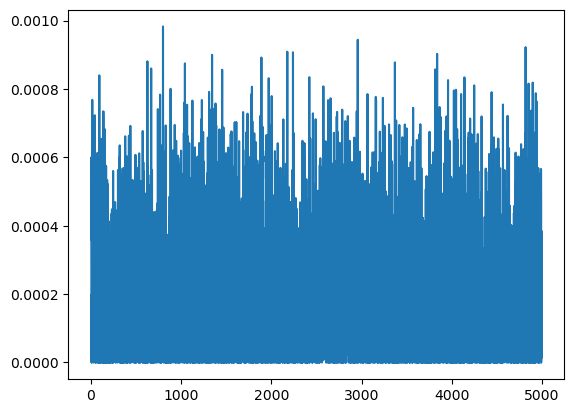

In [45]:
import matplotlib.pyplot as plt
plt.plot(q_list)

In [46]:
def leverage_weighed_sampling(q_list, num_samples, seed=0):
    np.random.seed(seed)
    sample = np.random.choice(len(q_list), size=num_samples, p=q_list, replace=True)
    sample.sort()
    return sample

In [257]:
idx = leverage_weighed_sampling(q_list, 100)
newfeatures = features[:,idx]
Qlist = np.sqrt(1/q_list[idx])

In [ ]:
class WRFLAF(nn.Module):
    def __init__(self, features, Q, coef, output_dim=1, h=0.02, N=401, L=-2, R=2, seed=0):
        super(WRFLAF, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
        hlist=h * np.ones(N)
        clist=np.linspace(L, R, N)
        paralist = list(zip(clist, hlist))
        
        input_dim, hidden_dim = features.shape
              
        self.W = nn.Parameter(torch.tensor(features), requires_grad=False)
        print('weight matrix size [d, M]:', tuple(self.W.shape))
        
        self.a = nn.Parameter(torch.tensor(coef))
        print('coef size: [N]', tuple(self.a.shape)[0])
        
        if output_dim==1:
            self.v = nn.Parameter(torch.randn(hidden_dim)/torch.sqrt(torch.tensor(hidden_dim*1.0)))
        else:
            self.v = nn.Parameter(torch.randn(hidden_dim, output_dim)/torch.sqrt(torch.tensor(hidden_dim*1.0)))
            
        self.Q = nn.Parameter(torch.tensor(Q), requires_grad=False)
        
        self.rbfs = nn.ModuleList([RBFLayer(torch.tensor(center), torch.tensor(gamma)) for center, gamma in paralist])

    def forward(self, x):
        # x: [batch_size, input_dim]
        x = x.view(x.size(0), -1)  # Flatten input
        xW = torch.matmul(x, self.W)  # [batch_size, M]
        A = torch.stack([rbf(xW) for rbf in self.rbfs], dim=2) # [batch_size, M, N]
        Aa = torch.matmul(A, self.a) # [batch_size, M]
        AaQ = Aa * self.Q  # [batch_size, M]
        vAa = torch.matmul(AaQ, self.v) # [batch_size]
        return vAa

In [ ]:
model = WRFLAF(newfeatures, Qlist, coef, output_dim=10, h=4/(N-1), N=N, seed=seed)

weight matrix size [d, M]: (3072, 100)
coef size: [N] 17


In [ ]:
class RidgeRegressionRegularizer(nn.Module):
    def __init__(self, lambda0, M):
        super(RidgeRegressionRegularizer, self).__init__()
        self.lambda0 = torch.tensor(lambda0)
        self.M = torch.tensor(M*1.0)

    def forward(self, v):
        reg_term = self.lambda0 * self.M * torch.sum(v**2)
        return reg_term

In [4]:
def find_ridge_args(data, model, propty, seed, s, M, N=17, L=-2, R=2, lambda1=1, lambda2=0):
    h = 4/(N-1)
    if model=='RFLAF':
        actfunc = 'LAF'
        moreargs=f'h={h}_N={N}_L={L}_R={R}_s={s}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFLAFBS':
        actfunc = 'BS'
        moreargs=f'N={N}_L={L}_R={R}_s={s}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFMLP':
        actfunc = 'relu'
        moreargs=f's={s}_M={M}'
    
    if data in ['ct', 'protein', 'workloads']:
        epochs = 20
    elif data in ['adult', 'cifar10']:
        epochs = 10
    
    foldername={
        'test_loss': 'losses',
        'train_loss': 'losses',
        'test_acc': 'accuracies',
        'train_acc': 'accuracies',
        'test_time': 'times',
        'train_time': 'times',
        'coef': 'coef',
        'features': 'features',
    }
    if propty=='coef':
        return f"./ridge/{foldername[propty]}/{data}_{actfunc}_{propty}_seed={seed}_epoch={epochs}_{moreargs}_{epochs}.txt"
    else:
        return f"./ridge/{foldername[propty]}/{data}_{actfunc}_{propty}_seed={seed}_epoch={epochs}_{moreargs}.txt"

In [73]:
from collections import defaultdict
ridgedict=dict()
data_list = ['adult', 'cifar10', 'ct', 'workloads']
model_list = ['RFLAF']#, 'RFMLP', 'RFLAFBS']
property_list = ['test_loss', 'train_loss', 'test_acc', 'train_acc']
N_list = [17, 33, 65]
h_list = [0.25, 0.125, 0.0625]
modelseed_list = [402025, 102025, 202025, 302025, 3070, 4080, 5090, 20250101]
for data in data_list:
    for model in model_list:
        for h, N in zip(h_list, N_list):
            taskname = data+model+f'{N}'
            ridgedict[taskname] = defaultdict(list)
            for M in M_list:
                for property in property_list:
                    if data in ['ct', 'workloads'] and property[-3:]=='acc':
                        continue
                    tmparr = []
                    try:
                        for seed in modelseed_list:
                            tmparr.append(np.loadtxt(find_ridge_args(data, model, property, seed, M, 5000, N)))
                        tmparr = np.array(tmparr).mean(axis=0)
                        if property[-4:]=='loss':
                            tmp = float(tmparr.min())
                        elif property[-3:]=='acc':
                            tmp = float(tmparr.max())
                        ridgedict[taskname][property].append(tmp)
                    except FileNotFoundError:
                        print(f"not found {find_ridge_args(data, model, property, seed, M, 5000, N)}")
                        continue

not found ./ridge/losses/ct_LAF_test_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=10_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_train_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=10_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_test_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=30_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_train_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=30_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_test_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=50_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_train_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=50_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_test_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=100_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/losses/ct_LAF_train_loss_seed=202025_epoch=20_h=0.0625_N=65_L=-2_R=2_s=100_M=5000_lambda1=1_lambda2=0.txt
not found ./ridge/

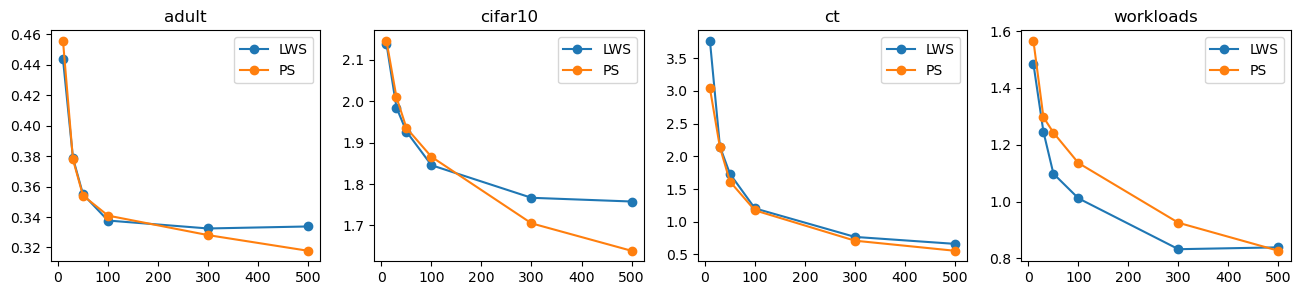

In [80]:
N=17
show = 6

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for i, data in enumerate(data_list):
    ax[i].plot(s_list[:show], ridgedict[data+model+f'{N}']['test_loss'][:show], marker='o')
    ax[i].plot(M_list[:show], datadict[data+model+f'{N}']['test_loss'][:show], marker='o')
    ax[i].legend(['LWS', 'PS'])
    ax[i].set_title(data)

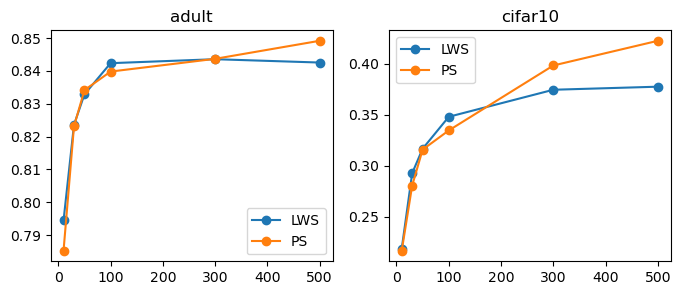

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for i, data in enumerate(data_list[:2]):
    ax[i].plot(s_list[:show], ridgedict[data+model+f'{N}']['test_acc'][:show], marker='o')
    ax[i].plot(M_list[:show], datadict[data+model+f'{N}']['test_acc'][:show], marker='o')
    ax[i].legend(['LWS', 'PS'])
    ax[i].set_title(data)

In [1]:
! CUDA_VISIBLE_DEVICES=5 python3 ridge.py --model RFLAF --data ct --epochs 20 --h 0.0625 --N 65 --M 5000 --modelseed 402025

Using device: cuda
GPU: 5
Loading weight matrix...
Use datasets: ct
train size: 42800
test size: 10700
Calculating leverage scores...
weight matrix size [d, M]: (384, 5000)
coef size: [N] 65
Dataset: ct, effective dimension=54627.75
Weighet sampling RF number: newM=10
Loading data ct
Data dimension: 384
Use datasets: ct
train size: 42800
test size: 10700
Finished loading data ct
Using model RFLAF, modelseed=402025
RBF params:	h=0.0625	N=65	L=-2	R=2
weight matrix size [d, M]: (384, 10)
coef size: [N] 65
Start training model RFLAF on data ct...
Epoch 1/20, Train Loss: 43.4565, Test Loss: 5.4274                              
Epoch 2/20, Train Loss: 5.2510, Test Loss: 4.8783                               
Epoch 3/20, Train Loss: 4.8495, Test Loss: 4.5464                               
Epoch 4/20, Train Loss: 4.4955, Test Loss: 4.1872                               
Epoch 5/20, Train Loss: 4.1322, Test Loss: 3.8467                               
Epoch 6/20, Train Loss: 3.8000, Test Loss: 3.5

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [69]:
from scipy.stats import sem, t
def mean_plot(ax, M_list, losses, color, label):
    mean_loss = np.mean(losses, axis=1)
    n = losses.shape[1]
    confidence = 0.95
    stderr = sem(losses, axis=1)
    h = stderr * t.ppf((1 + confidence) / 2., n-1)
    ax.plot(M_list, mean_loss, color=color, label=label, marker='.')
    ax.fill_between(M_list, mean_loss - h, mean_loss + h, color=color, alpha=0.2)

def getbigm(data, N):
    if data=='workloads':
        return 1000
    if data=='cifar10' and N==65:
        return 5000
    if data=='cifar10' and model=='RFLAFBS':
        return 3000
    return 5000


def find_args(data, model, property, seed, M, N=17, L=-2, R=2, lambda1=1, lambda2=0):
    h = 4/(N-1)
    if model=='RFLAF':
        actfunc = 'LAF'
        moreargs=f'h={h}_N={N}_L={L}_R={R}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFLAFBS':
        actfunc = 'BS'
        moreargs=f'N={N}_L={L}_R={R}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFMLP':
        actfunc = 'relu'
        moreargs=f'M={M}'
    
    if data in ['ct', 'protein', 'workloads']:
        epochs = 20
    elif data in ['adult', 'cifar10']:
        epochs = 10
    
    foldername={
        'test_loss': 'losses',
        'train_loss': 'losses',
        'test_acc': 'accuracies',
        'train_acc': 'accuracies',
        'test_time': 'times',
        'train_time': 'times',
        'coef': 'coef',
        'features': 'features',
    }
    if property=='coef':
        return f"./{foldername[property]}/{data}_{actfunc}_{property}_seed={seed}_epoch={epochs}_{moreargs}_{epochs}.txt"
    else:
        return f"./{foldername[property]}/{data}_{actfunc}_{property}_seed={seed}_epoch={epochs}_{moreargs}.txt"
    
def find_ridge_args(data, model, propty, seed, s, M, N=17, L=-2, R=2, lambda1=1, lambda2=0):
    h = 4/(N-1)
    if model=='RFLAF':
        actfunc = 'LAF'
        moreargs=f'h={h}_N={N}_L={L}_R={R}_s={s}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFLAFBS':
        actfunc = 'BS'
        moreargs=f'N={N}_L={L}_R={R}_s={s}_M={M}_lambda1={lambda1}_lambda2={lambda2}'
    elif model=='RFMLP':
        actfunc = 'relu'
        moreargs=f's={s}_M={M}'
    
    if data in ['ct', 'protein', 'workloads']:
        epochs = 20
    elif data in ['adult', 'cifar10']:
        epochs = 10
    
    foldername={
        'test_loss': 'losses',
        'train_loss': 'losses',
        'test_acc': 'accuracies',
        'train_acc': 'accuracies',
        'test_time': 'times',
        'train_time': 'times',
        'coef': 'coef',
        'features': 'features',
    }
    if propty=='coef':
        return f"./ridge/{foldername[propty]}/{data}_{actfunc}_{propty}_seed={seed}_epoch={epochs}_{moreargs}_{epochs}.txt"
    else:
        return f"./ridge/{foldername[propty]}/{data}_{actfunc}_{propty}_seed={seed}_epoch={epochs}_{moreargs}.txt"

In [70]:
modelseed_list = [402025, 102025, 202025, 302025, 3070, 4080, 5090, 20250101]
N_list = [17, 33, 65]
h_list = [0.25, 0.125, 0.0625]
M_list = [10, 30, 50, 100, 300, 500, 1000, 3000, 5000]

datadict=dict()
data_list = ['adult', 'cifar10', 'protein', 'workloads']
model_list = ['RFLAF']#, 'RFMLP', 'RFLAFBS']
property_list = ['test_loss', 'train_loss', 'test_acc', 'train_acc']

data_list = ['adult', 'cifar10', 'protein', 'workloads']
model_list = ['RFLAFBS']
N_list = [33]
h_list = [0.125]


for data in data_list:
    for model in model_list:
        for h, N in zip(h_list, N_list):
            taskname = data+model+f'{N}'
            datadict[taskname] = defaultdict(list)
            for property in property_list:
                if data in ['protein', 'workloads'] and property[-3:]=='acc':
                    continue
                for M in M_list:    
                    tmparr = []
                    for seed in modelseed_list:
                        try:
                            tmparr.append(np.loadtxt(find_args(data, model, property, seed, M, N)))
                        except FileNotFoundError:
                            print(f"not found {find_args(data, model, property, seed, M, N)}")
                            continue
                    tmparr = np.array(tmparr)
                    if property[-4:]=='loss':
                        tmp = tmparr.min(axis=1)
                    elif property[-3:]=='acc':
                        tmp = tmparr.max(axis=1)
                    datadict[taskname][property].append(tmp)
                datadict[taskname][property] = np.array(datadict[taskname][property])

In [71]:
ridgedict=dict()
for data in data_list:
    for model in model_list:
        for h, N in zip(h_list, N_list):
            taskname = data+model+f'{N}'
            bigM = getbigm(data, N)
            ridgedict[taskname] = defaultdict(list)
            for property in property_list:
                if data in ['protein', 'workloads'] and property[-3:]=='acc':
                    continue
                for M in M_list:
                    if M > bigM:
                        break
                    tmparr = []
                    for seed in modelseed_list:
                        try:
                            tmparr.append(np.loadtxt(find_ridge_args(data, model, property, seed, M, bigM, N)))
                        except FileNotFoundError:
                            print(f"not found {find_ridge_args(data, model, property, seed, M, bigM, N)}")
                            continue
                    tmparr = np.array(tmparr)
                    if property[-4:]=='loss':
                        tmp = tmparr.min(axis=1)
                    elif property[-3:]=='acc':
                        tmp = tmparr.max(axis=1)
                    ridgedict[taskname][property].append(tmp)
                ridgedict[taskname][property] = np.array(ridgedict[taskname][property])

In [72]:
def lthmap(data, model, N):
    if data=='workloads':
        return 7, 7
    return 8, 9

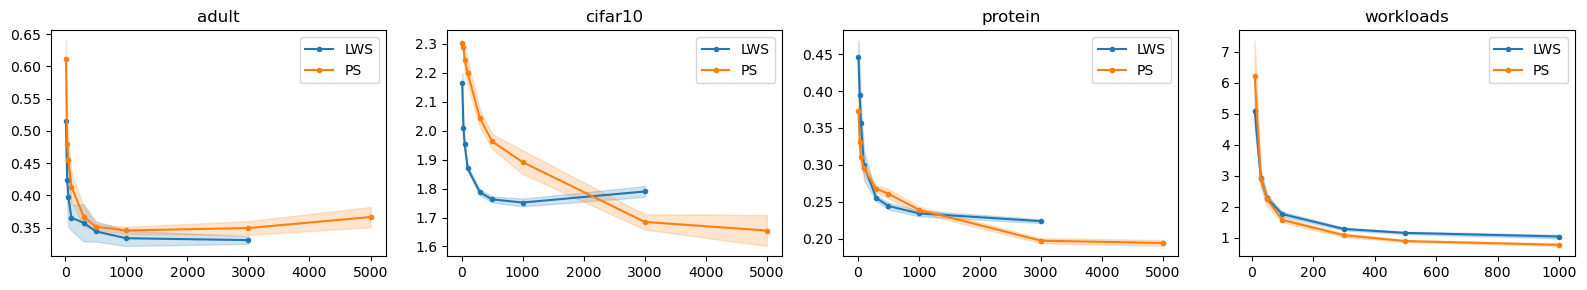

In [73]:
from scipy.stats import sem, t

# lth_list = [8,8,8,7]

N=33
model='RFLAFBS'
property='test_loss'

row, col = 1, 4
figsize = (col * 4, row * 3)

fig, ax = plt.subplots(row, col, figsize=figsize)
colors = ['#ff7f0e','#1f77b4']
for i, data in enumerate(data_list[:]):
    lth1, lth2 = lthmap(data, model, N)
    taskname = data+model+f'{N}'
    
    # if (data, model, N) == ('workloads', 'RFLAFBS', 17):
    #     ax[i].set_ylim(0.7, 1.6)

    mean_plot(ax[i], M_list[:lth1], ridgedict[taskname][property][:lth1], colors[1], 'LWS')
    mean_plot(ax[i], M_list[:lth2], datadict[taskname][property][:lth2], colors[0], 'PS')
    
    ax[i].set_title(data)
    ax[i].legend()
plt.tight_layout()

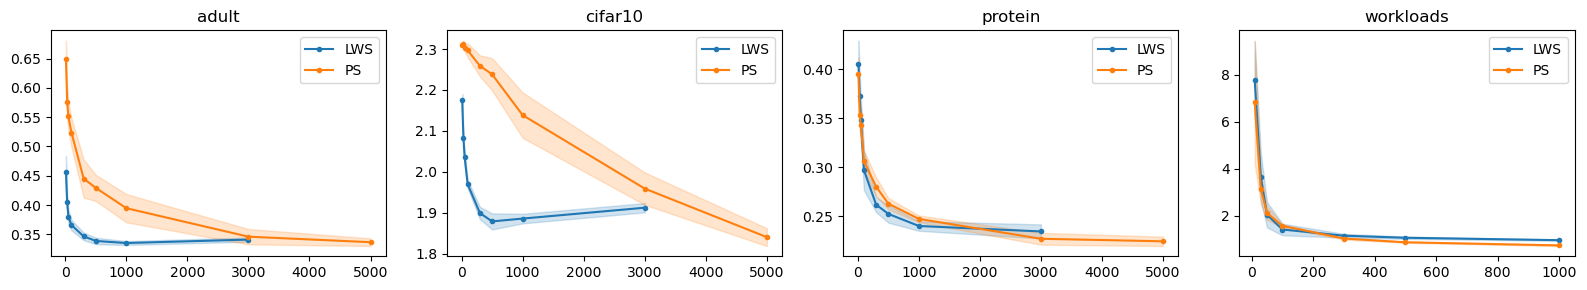

In [49]:
from scipy.stats import sem, t

# lth_list = [8,8,8,7]

N=17
model='RFLAFBS'
property='test_loss'

row, col = 1, 4
figsize = (col * 4, row * 3)

fig, ax = plt.subplots(row, col, figsize=figsize)
colors = ['#ff7f0e','#1f77b4']
for i, data in enumerate(data_list):
    lth1, lth2 = lthmap(data, model, N)
    taskname = data+model+f'{N}'
    
    # if (data, model, N) == ('workloads', 'RFLAFBS', 17):
    #     ax[i].set_ylim(0.7, 1.6)

    mean_plot(ax[i], M_list[:lth1], ridgedict[taskname][property][:lth1], colors[1], 'LWS')
    mean_plot(ax[i], M_list[:lth2], datadict[taskname][property][:lth2], colors[0], 'PS')
    
    ax[i].set_title(data)
    ax[i].legend()
plt.tight_layout()

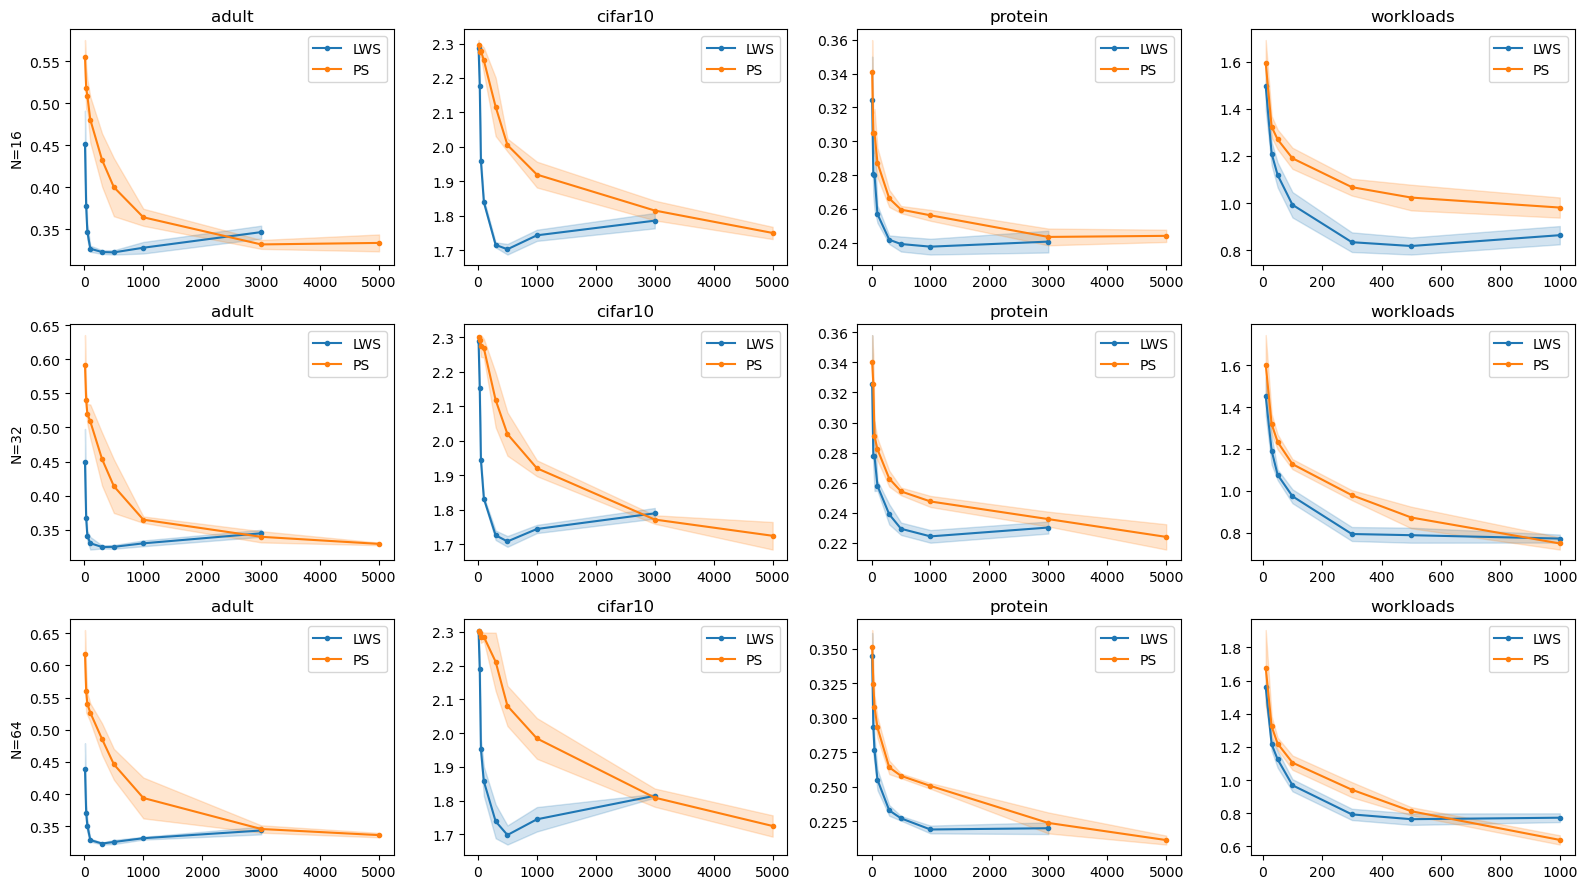

In [29]:
from scipy.stats import sem, t

# lth_list = [8,8,8,7]

N=65
model='RFLAF'
property='test_loss'

row, col = 3, 4
figsize = (col * 4, row * 3)

fig, ax = plt.subplots(row, col, figsize=figsize)
colors = ['#ff7f0e','#1f77b4']
for j, N in enumerate(N_list):
    for i, data in enumerate(data_list):
        lth1, lth2 = lthmap(data, model, N)
        taskname = data+model+f'{N}'
        
        mean_plot(ax[j][i], M_list[:lth1], ridgedict[taskname][property][:lth1], colors[1], 'LWS')
        mean_plot(ax[j][i], M_list[:lth2], datadict[taskname][property][:lth2], colors[0], 'PS')
        ax[j][i].set_title(data)
        ax[j][i].legend()
        if i==0:
            ax[j][i].set_ylabel(f'N={N-1}')
plt.tight_layout()